# Project for Generative AI
## Comparing effect of DAE on Noise Profiles
## Adi Ghosh and Zahra Rahmani

### Load Library files

In [61]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist, fashion_mnist, cifar10
import numpy as np
import cv2
import random
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model
from keras.callbacks import Callback
import keras.backend as K
import tensorflow as tf

## MNIST

### Load Image Data

In [43]:
(MNIST_X_train, MNIST_y_train), (MNIST_X_test, MNIST_y_test) = mnist.load_data()
print(MNIST_X_train.shape)
print(MNIST_X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


#### Plot Original Images

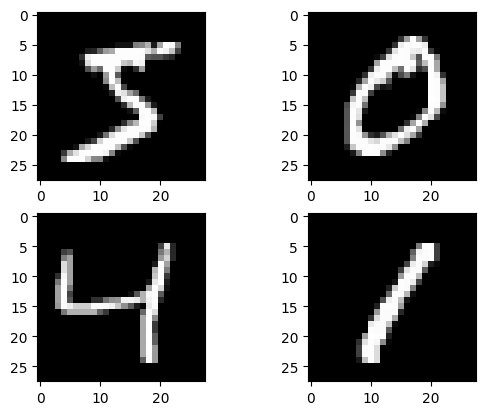

In [44]:
plt.subplot(221)
plt.imshow(MNIST_X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(MNIST_X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(MNIST_X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(MNIST_X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

### Add Noise to Image

#### Gaussian Noise

###### Add Noise

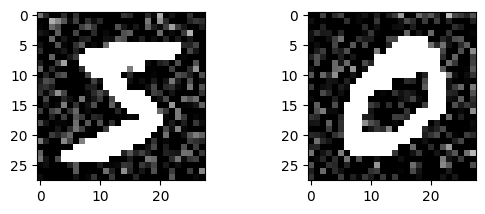

In [45]:
noise_factor = 0.25
# Add Gaussian noise
MNIST_x_train_guassian = MNIST_X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=MNIST_X_train.shape)
MNIST_x_test_guassian = MNIST_X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=MNIST_X_test.shape)

# Clip values to be between 0 and 1
MNIST_x_train_guassian = np.clip(MNIST_x_train_guassian, 0., 1.)
MNIST_x_test_guassian = np.clip(MNIST_x_test_guassian, 0., 1.)

# Reshape the data for visualization
MNIST_x_train_guassian_reshaped = MNIST_x_train_guassian.reshape(-1, 28, 28)
MNIST_x_test_guassian_reshaped = MNIST_x_test_guassian.reshape(-1, 28, 28)

# Visualize the noisy data
plt.subplot(221)
plt.imshow(MNIST_x_train_guassian_reshaped[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(MNIST_x_train_guassian_reshaped[1], cmap=plt.get_cmap('gray'))
# ... and so on for other subplots


###### Formatting Image Shape

In [46]:
num_pixels = MNIST_x_train_guassian.shape[1] * MNIST_x_train_guassian.shape[2]
MNIST_x_train_guassian = MNIST_x_train_guassian.reshape(MNIST_x_train_guassian.shape[0], num_pixels).astype('float32')
MNIST_x_test_guassian = MNIST_x_test_guassian.reshape(MNIST_x_test_guassian.shape[0], num_pixels).astype('float32')
MNIST_x_train_guassian = MNIST_x_train_guassian / 255
MNIST_x_test_guassian = MNIST_x_test_guassian / 255
print(MNIST_x_train_guassian.shape)
print(MNIST_x_test_guassian.shape)

(60000, 784)
(10000, 784)


#### Salt and Pepper Noise

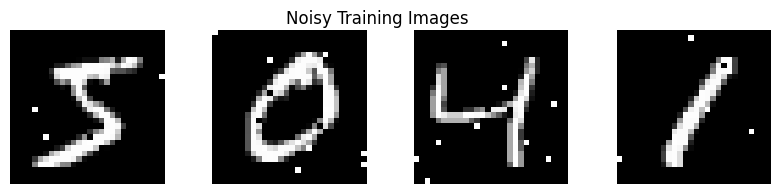

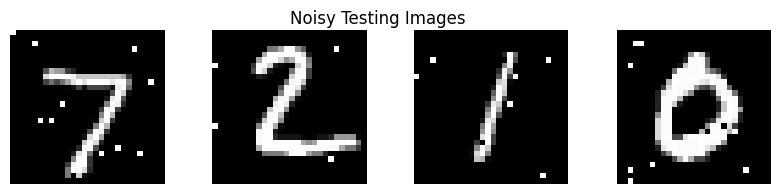

In [47]:
def salt_and_pepper_noise(X, salt_prob, pepper_prob):
    """
    Add salt and pepper noise to 2D image data.
    salt_prob: Probability of adding salt (white) noise.
    pepper_prob: Probability of adding pepper (black) noise.
    """
    noisy_images = np.copy(X)
    num_images, num_rows, num_cols = X.shape

    for i in range(num_images):
        for row in range(num_rows):
            for col in range(num_cols):
                rand = random.random()
                if rand < salt_prob:
                    noisy_images[i, row, col] = 255  # Salt noise
                elif rand < salt_prob + pepper_prob:
                    noisy_images[i, row, col] = 0    # Pepper noise

    return noisy_images

# Adjust these probabilities as needed
salt_prob = 0.01  # Probability of salt noise
pepper_prob = 0.01  # Probability of pepper noise

# Reshape MNIST data to 2D if it's not already
MNIST_x_train_reshaped = MNIST_X_train.reshape(-1, 28, 28)
MNIST_x_test_reshaped = MNIST_X_test.reshape(-1, 28, 28)

# Add salt-and-pepper noise to the MNIST data
MNIST_x_train_snp = salt_and_pepper_noise(MNIST_x_train_reshaped, salt_prob, pepper_prob)
MNIST_x_test_snp = salt_and_pepper_noise(MNIST_x_test_reshaped, salt_prob, pepper_prob)

# MNIST_X_train_noisy and MNIST_X_test_noisy contain the noisy images.

def plot_noisy_images(images, num_images=4, title="Noisy Images"):
    """
    Plot the first few images from the noisy dataset.
    images: Noisy images dataset.
    num_images: Number of images to display.
    title: Title for the plot.
    """
    plt.figure(figsize=(10, 2))
    plt.suptitle(title)
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Plot the first few noisy training images
plot_noisy_images(MNIST_x_train_snp, num_images=4, title="Noisy Training Images")

# Plot the first few noisy testing images
plot_noisy_images(MNIST_x_test_snp, num_images=4, title="Noisy Testing Images")

###### Formatting Image Shape

In [48]:
num_pixels = MNIST_x_train_snp.shape[1] * MNIST_x_train_snp.shape[2]
MNIST_x_train_snp = MNIST_x_train_snp.reshape(MNIST_x_train_snp.shape[0], num_pixels).astype('float32')
MNIST_x_test_snp = MNIST_x_test_snp.reshape(MNIST_x_test_snp.shape[0], num_pixels).astype('float32')
MNIST_x_train_snp = MNIST_x_train_snp / 255
MNIST_x_test_snp = MNIST_x_test_snp / 255
print(MNIST_x_train_snp.shape)
print(MNIST_x_test_snp.shape)

(60000, 784)
(10000, 784)


##### Uniform Noise

###### Add Noise

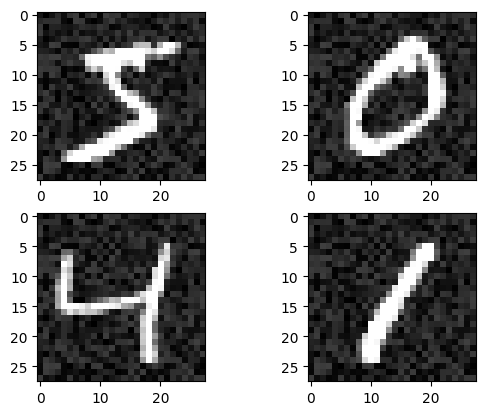

In [49]:
noise_factor = 0.25
uni_noise=np.zeros((28,28),dtype=np.uint8)
cv2.randu(uni_noise,0,255)
uni_noise=(uni_noise*noise_factor).astype(np.uint8)
MNIST_x_train_uniform=[]
MNIST_x_test_uniform=[]
for i in range(0,MNIST_X_train.shape[0]):
    img=cv2.add(MNIST_X_train[i],uni_noise)
    MNIST_x_train_uniform.append(img)
for i in range(0,MNIST_X_test.shape[0]):
    img=cv2.add(MNIST_X_test[i],uni_noise)
    MNIST_x_test_uniform.append(img)
MNIST_x_train_uniform = np.array(MNIST_x_train_uniform)
MNIST_x_test_uniform = np.array(MNIST_x_test_uniform)
plt.subplot(221)
plt.imshow(MNIST_x_train_uniform[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(MNIST_x_train_uniform[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(MNIST_x_train_uniform[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(MNIST_x_train_uniform[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

###### Formatting Image Shape

In [50]:
num_pixels = MNIST_x_train_uniform.shape[1] * MNIST_x_train_uniform.shape[2]
MNIST_x_train_uniform = MNIST_x_train_uniform.reshape(MNIST_x_train_uniform.shape[0], num_pixels).astype('float32')
MNIST_x_test_uniform = MNIST_x_test_uniform.reshape(MNIST_x_test_uniform.shape[0], num_pixels).astype('float32')
MNIST_x_train_uniform = MNIST_x_train_uniform / 255
MNIST_x_test_uniform = MNIST_x_test_uniform / 255
print(MNIST_x_train_uniform.shape)
print(MNIST_x_test_uniform.shape)

(60000, 784)
(10000, 784)


#### Quantization Noise

#### Random Noise

###### Add Noise

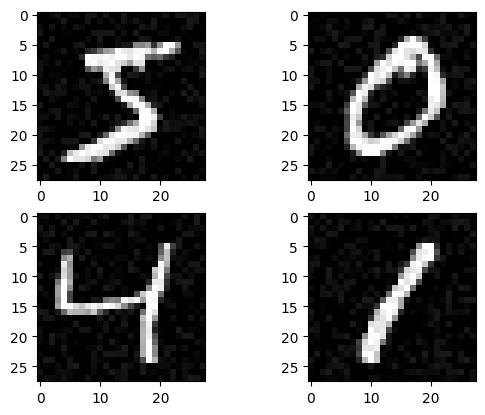

In [51]:
noise_factor = 0.25
MNIST_x_train_random=[]
MNIST_x_test_random=[]
intensity = noise_factor*100
for i in range(0,MNIST_X_train.shape[0]):
    noisy_image = MNIST_X_train[i].copy()
    noise = np.random.randint(-intensity, intensity + 1, noisy_image.shape)
    noisy_image = np.clip(noisy_image + noise, 0, 255).astype(np.uint8)
    MNIST_x_train_random.append(noisy_image)
for i in range(0,MNIST_X_test.shape[0]):
    noisy_image = MNIST_X_test[i].copy()
    noise = np.random.randint(-intensity, intensity + 1, noisy_image.shape)
    noisy_image = np.clip(noisy_image + noise, 0, 255).astype(np.uint8)
    MNIST_x_test_random.append(noisy_image)
MNIST_x_train_random = np.array(MNIST_x_train_random)
MNIST_x_test_random = np.array(MNIST_x_test_random)
plt.subplot(221)
plt.imshow(MNIST_x_train_random[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(MNIST_x_train_random[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(MNIST_x_train_random[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(MNIST_x_train_random[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

###### Formatting Image Shape

In [52]:
num_pixels = MNIST_x_train_random.shape[1] * MNIST_x_train_random.shape[2]
MNIST_x_train_random = MNIST_x_train_random.reshape(MNIST_x_train_random.shape[0], num_pixels).astype('float32')
MNIST_x_test_random = MNIST_x_test_uniform.reshape(MNIST_x_test_random.shape[0], num_pixels).astype('float32')
MNIST_x_train_random = MNIST_x_train_random / 255
MNIST_x_test_random = MNIST_x_test_random / 255
print(MNIST_x_train_random.shape)
print(MNIST_x_test_random.shape)

(60000, 784)
(10000, 784)


#### Periodic Noise

## DAE Architecture

### Architecture 1

#### Input Layer

In [53]:
input_layer = Input(shape=(784,))

##### Encoder

In [54]:
x = Reshape((28, 28, 1))(input_layer)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#### Decoder

In [55]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

#### Define KL Divergence function

In [58]:
def kl_divergence(y_true, y_pred):
    # Ensure values are in valid range (0, 1)
    y_true = tf.clip_by_value(y_true, 1e-10, 1.0 - 1e-10)
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0 - 1e-10)
    
    # Calculate KL divergence
    kl = tf.reduce_sum(y_true * tf.math.log(y_true / y_pred), axis=-1)
    
    return kl

#### Define model

In [59]:
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[kl_divergence])

#### Train model

In [60]:
autoencoder.fit(MNIST_x_train_guassian, MNIST_X_train, epochs=10, batch_size=128, validation_data=(MNIST_x_test_guassian, MNIST_X_test))

Epoch 1/10


NotImplementedError: in user code:

    File "c:\Python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Adi\AppData\Local\Temp\ipykernel_41104\2874276852.py", line 3, in kl_divergence  *
        y_true = np.clip(y_true, 1e-10, 1.0 - 1e-10)
    File "<__array_function__ internals>", line 200, in clip  **
        
    File "C:\Users\Adi\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py", line 2180, in clip
        return _wrapfunc(a, 'clip', a_min, a_max, out=out, **kwargs)
    File "C:\Users\Adi\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py", line 54, in _wrapfunc
        return _wrapit(obj, method, *args, **kwds)
    File "C:\Users\Adi\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py", line 43, in _wrapit
        result = getattr(asarray(obj), method)(*args, **kwds)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (Cast_31:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


### Evaluation

##### Generate Denoised Images

313/313 [==============================] - 2s 7ms/step


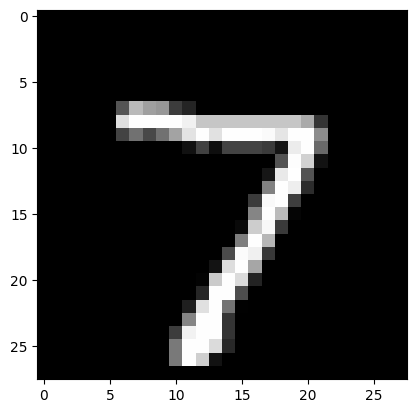

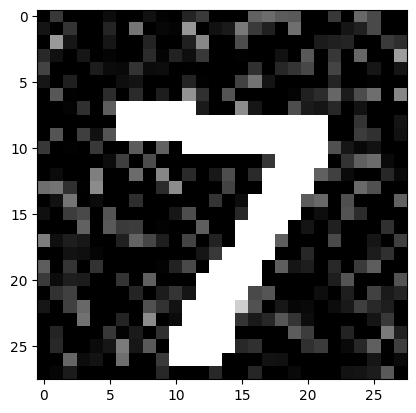

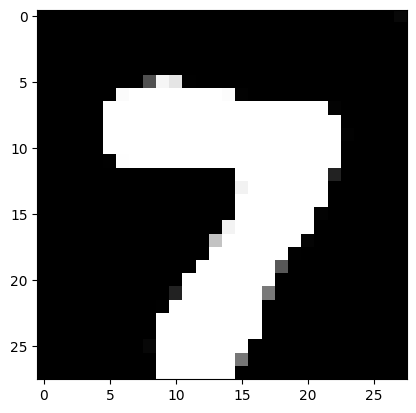

In [36]:
denoised_images = autoencoder.predict(MNIST_x_test_guassian)
# Display the first image in the test set
plt.imshow(MNIST_X_test[0], cmap='gray')
plt.show()

# Display the first image in the noisy test set
plt.imshow(MNIST_x_test_guassian[0].reshape(28, 28), cmap='gray')
plt.show()

# Display the first image in the denoised test set
plt.imshow(denoised_images[0].reshape(28, 28), cmap='gray')
plt.show()

#### Get Final KL Divergence value

In [ ]:
final_kl_divergence = autoencoder.evaluate(MNIST_x_test_guassian, MNIST_X_test, verbose=0)[1]
print("Final KL Divergence:", final_kl_divergence)

### Architecture 2

## Network

### Training

In [ ]:
# Training model
model.fit(x_train_noisy, X_train, validation_data=(x_test_noisy, X_test), epochs=2, batch_size=200)

### Evaluation

#### Plot Original vs Reconstructed Images

In [ ]:
# Final evaluation of the model
pred = model.predict(x_test_noisy)
X_test = numpy.reshape(X_test, (10000,28,28)) *255
pred = numpy.reshape(pred, (10000,28,28)) *255
x_test_noisy = numpy.reshape(x_test_noisy, (-1,28,28)) *255
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i,:,:], cmap='gray')
    curr_lbl = y_test[i]
    plt.title("(Label: " + str(curr_lbl) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i,:,:], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i,:,:], cmap='gray')  
plt.show()

#### Plot graphs between KL-Divergence and noise-architecture combinations